<a href="https://colab.research.google.com/github/Hamza-Ali0237/CIFAR10-Web_App/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Main Libraries

In [1]:
# from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-02-12 12:58:27.051274: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 12:58:27.087329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 12:58:27.087362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 12:58:27.088264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 12:58:27.093977: I tensorflow/core/platform/cpu_feature_guar

## Mounting Google Drive

In [2]:
# drive.mount('/content/drive')

## Loading The Dataset

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 652s 4us/step


In [4]:
num_of_classes = 10

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Visualising The Data

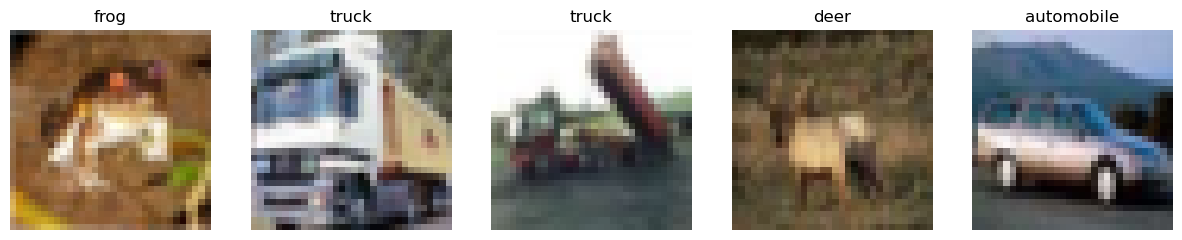

In [5]:
# Display images with class labels
plt.figure(figsize=(15, 3))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')

plt.show()

### Normalizing the data

In [6]:
X_train, X_test = X_train/255. , X_test/255.

### One-hot Encoding

In [7]:
num_classes = 10

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [8]:
# Display dataset shapes
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


## Creating Model (ResNet50)

In [9]:
res_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
    )

# To freeze ResNet50 model layers
# for layer in res_model.layers:
#   layer.trainable = False

2024-02-12 13:09:27.135433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-02-12 13:09:27.136001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6307 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:65:00.0, compute capability: 7.5


In [10]:
model = Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(res_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_of_classes, activation='softmax'))

## Training The Model

In [11]:
# Flattening Y_train to avoid error
y_train_integer = y_train.reshape(-1)

In [12]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [13]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

In [16]:
model_checkpoint = ModelCheckpoint(
    filepath='/home/craib/Desktop/CIFAR10-Web_App/ResNet50_cifar10_best_2.h5',
    monitor='val_acc',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [17]:
history = model.fit(X_train, y_train_integer, validation_split=0.1, epochs=15, callbacks=[early_stopping, model_checkpoint])

Epoch 1/15
1407/1407 [==============================] - ETA: 0s - loss: 0.8466 - acc: 0.7615WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,acc,val_loss,val_acc

Epoch 1: val_acc improved from -inf to 0.91480, saving model to /home/craib/Desktop/CIFAR10-Web_App/ResNet50_cifar10_best_2.h5


/home/craib/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 313s 222ms/step - loss: 0.8466 - acc: 0.7615 - val_loss: 0.3593 - val_acc: 0.9148
Epoch 2/15
1407/1407 [==============================] - ETA: 0s - loss: 0.6101 - acc: 0.8514WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,acc,val_loss,val_acc

Epoch 2: val_acc did not improve from 0.91480
1407/1407 [==============================] - 313s 223ms/step - loss: 0.6101 - acc: 0.8514 - val_loss: 0.3318 - val_acc: 0.9100
Epoch 3/15
1407/1407 [==============================] - ETA: 0s - loss: 0.4578 - acc: 0.8986WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,acc,val_loss,val_acc

Epoch 3: val_acc improved from 0.91480 to 0.93080, saving model to /home/craib/Desktop/CIFAR10-Web_App/ResNet50_cifar10_best_2.h5
1407/1407 [==============================] - 314s 223ms/step - loss: 0.4578 - acc: 0.8986 - val_

## Save Model To Google Drive

In [18]:
# drive_save_path = '/content/drive/My Drive/ResNet50_cifar10_2.h5'

In [19]:
# model.save(drive_save_path)

In [20]:
model.save('ResNet50_cifar10_best_fr.h5')

## Evaluate Model Performance

In [21]:
# Loading Model From Drive
model_best = load_model('/content/drive/My Drive/ResNet50_cifar10_best.h5')

OSError: No file or directory found at /content/drive/My Drive/ResNet50_cifar10_best.h5

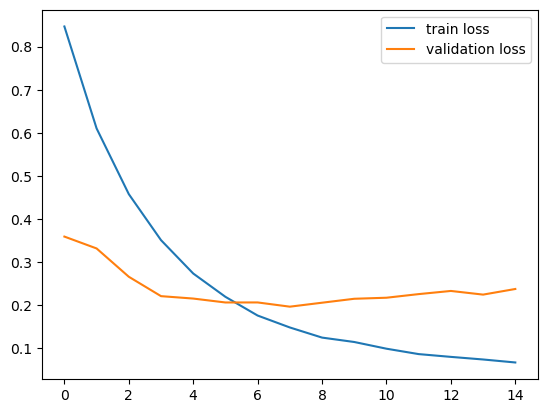

In [22]:
# plot the loss value
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

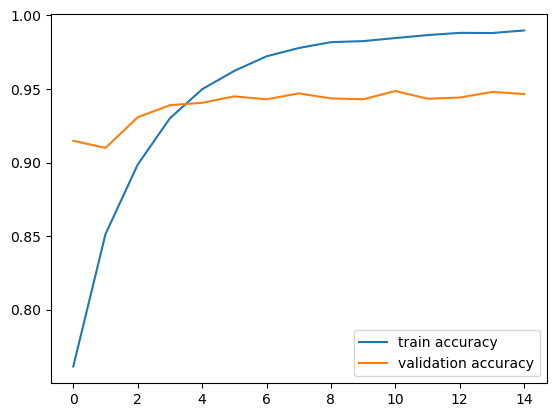

In [23]:
# plot the accuracy value
plt.plot(history.history['acc'], label='train accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

In [24]:
# Evaluate model on test data
y_test_integer = np.argmax(y_test_categorical, axis=1)
eval_result = model_best.evaluate(X_test, y_test_integer)

print("Test Loss:", eval_result[0])
print("Test Accuracy:", eval_result[1])

NameError: name 'model_best' is not defined